# Best mutation on background

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


# Best mutations on BA.2

In [22]:
BQ='SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
len(BQ)#it is actually BA2
BQ_SEQ=Proteins_utils.seq2num(BQ)
# BQ: amino-acid sequence string already defined
# Example:
# BQ = "MFVFLVLLPLVSSQCV..."  # Spike or any protein

AA = "ACDEFGHIKLMNPQRSTVWY"

def wrap60(s):
    return "\n".join(s[i:i+60] for i in range(0, len(s), 60))

def write_single_mutants_fasta(wt_seq, out_path="../seq_data/BA2_single_mutants.fasta", prefix="BQ"):
    n_written = 0
    with open(out_path, "w") as f:
        for i, wt in enumerate(wt_seq, start=1):
            if wt not in AA:
                continue  # skip non-canonical sites
            for alt in AA:
                if alt == wt:
                    continue
                mut = f"{wt}{i}{alt}"
                seq = wt_seq[:i-1] + alt + wt_seq[i:]
                f.write(f">{prefix}_{mut}\n{wrap60(seq)}\n")
                n_written += 1
    print(f"Wrote {n_written} single mutants to {out_path}")

# run
write_single_mutants_fasta(BQ, out_path="../seq_data/BA2_single_mutants.fasta", prefix="BQ")


Wrote 3382 single mutants to ../seq_data/BA2_single_mutants.fasta


In [21]:
seqs_batch=Proteins_utils.load_FASTA("../seq_data/BA2_single_mutants.fasta")


# No Ab

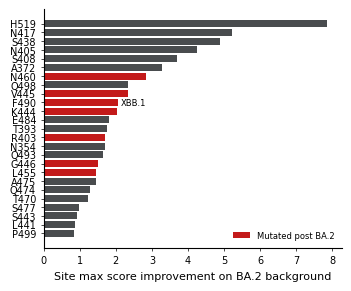

In [27]:
em_path = "../params_by_period_0.03_m1_m8_m7/param_period_2022-01-01.csv"
import torch
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS)
model.raw_concentrations=torch.tensor([-10])
scores_diff=score_seq_batch(model, seqs_batch)+model(BQ_SEQ)
import matplotlib.pyplot as plt
import pandas as pd

# Inputs you already have:
# BQ: wild-type sequence string
# scores_diff: 1D numpy array with scores for ALL single mutants generated in order:
#   for pos in 1..L, for aa in AA if aa != wt[pos], write mutant

AA = "ACDEFGHIKLMNPQRSTVWY"  # canonical 20 AA

def max_per_site_from_single_mutants(wt_seq, scores, alphabet=AA):
    L = len(wt_seq)
    # how many mutants per site (19 if canonical WT, else 0 because skipped)
    per_site_counts = []
    for i in range(L):
        wt = wt_seq[i]
        if wt in alphabet:
            per_site_counts.append(len(alphabet) - 1)  # exclude WT
        else:
            per_site_counts.append(0)  # no mutants were generated for non-canonical WT

    expected = sum(per_site_counts)
    if scores.shape[0] != expected:
        raise ValueError(f"Length mismatch: got {scores.shape[0]} scores, expected {expected} "
                         f"from sequence length {L} and generation scheme.")

    # slice scores per site and take max
    out_rows = []
    idx = 0
    for i in range(L):
        wt = wt_seq[i]
        k = per_site_counts[i]
        if k == 0:
            idx += 0
            continue
        site_scores = scores[idx:idx+k]
        idx += k
        out_rows.append({"pos": i + 1+348, "wt": wt, "max_score": float(np.max(site_scores))})

    df = pd.DataFrame(out_rows)
    return df

# Compute table
df_max = max_per_site_from_single_mutants(BQ, scores_diff, alphabet=AA)
# Optional: sort by position
df_max = df_max.sort_values("pos").reset_index(drop=True)

# Compute table
scores_diff = max_per_site_from_single_mutants(BQ, scores_diff, alphabet=AA)
# Optional: sort by position
scores_diff = scores_diff.sort_values("pos").reset_index(drop=True)

# Labels like "A123"
labels = scores_diff.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = scores_diff["max_score"].to_numpy()
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max.nlargest(25, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()

ba2_new_mut = {346, 356, 368, 403, 444, 445, 446, 450, 452, 455, 456, 460, 481, 486, 490}
# Mapping of key BA.2 sublineage mutations to appearance variants
site_to_variant = {
    490: "XBB.1",
    486: "BA.2.75.2",
    452: "BA.2.12.1",
    456: "EG.5",
    450: "BA.2.3.20",
    # Add others if needed
}

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

# Small PRL-style figure (~1 column width, 8.6 cm)
fig, ax = plt.subplots(figsize=(3.4, 2.8))

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement on BA.2 background", fontsize=8)

# Clean frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()




# Small model

In [24]:
em_path = "../params_by_period_0.03_m1_m8_m7/param_period_2022-01-01.csv"
import torch
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS)
scores_diff_small=score_seq_batch(model, seqs_batch)+model(BQ_SEQ)
scores_diff_small

array([ -5.83042959, -13.62083486,  -5.77745107, ...,  -7.6524019 ,
       -15.95118199,  -7.42570035])

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Inputs you already have:
# BQ: wild-type sequence string
# scores_diff: 1D numpy array with scores for ALL single mutants generated in order:
#   for pos in 1..L, for aa in AA if aa != wt[pos], write mutant

AA = "ACDEFGHIKLMNPQRSTVWY"  # canonical 20 AA

def max_per_site_from_single_mutants(wt_seq, scores, alphabet=AA):
    L = len(wt_seq)
    # how many mutants per site (19 if canonical WT, else 0 because skipped)
    per_site_counts = []
    for i in range(L):
        wt = wt_seq[i]
        if wt in alphabet:
            per_site_counts.append(len(alphabet) - 1)  # exclude WT
        else:
            per_site_counts.append(0)  # no mutants were generated for non-canonical WT

    expected = sum(per_site_counts)
    if scores.shape[0] != expected:
        raise ValueError(f"Length mismatch: got {scores.shape[0]} scores, expected {expected} "
                         f"from sequence length {L} and generation scheme.")

    # slice scores per site and take max
    out_rows = []
    idx = 0
    for i in range(L):
        wt = wt_seq[i]
        k = per_site_counts[i]
        if k == 0:
            idx += 0
            continue
        site_scores = scores[idx:idx+k]
        idx += k
        out_rows.append({"pos": i + 1+348, "wt": wt, "max_score": float(np.max(site_scores))})

    df = pd.DataFrame(out_rows)
    return df

# Compute table
df_max_small = max_per_site_from_single_mutants(BQ, scores_diff_small, alphabet=AA)
# Optional: sort by position
df_max_small = df_max_small.sort_values("pos").reset_index(drop=True)

# Labels like "A123"
labels = df_max_small.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = df_max_small["max_score"].to_numpy()




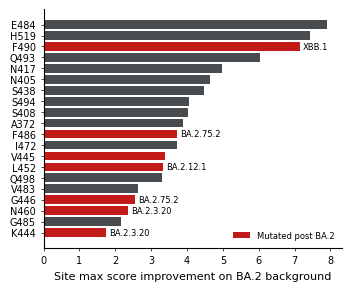

In [33]:
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max_small.nlargest(20, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()

ba2_new_mut = {346, 356, 368, 403, 444, 445, 446, 450, 452, 455, 456, 460, 481, 486, 490}

# Mapping of key BA.2 sublineage mutations to appearance variants
site_to_variant = {
    490: "XBB.1",
    486: "BA.2.75.2",
    452: "BA.2.12.1",
    456: "EG.5",
    450: "BA.2.3.20",
    446: "BA.2.75.2",
    460: "BA.2.3.20",
    455: "JN.1",
    444: "BA.2.3.20",
    # Add others if needed
}

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

# Small PRL-style figure (~1 column width, 8.6 cm)
fig, ax = plt.subplots(figsize=(3.4, 2.8))

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement on BA.2 background", fontsize=8)

# Clean frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()


# FUll model

In [29]:
em_path = "../params_by_period_0.03_m1_m8_m7_full/param_period_2022-01-01.csv"
import torch
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS|BA1_KD_VECTORS)
scores_diff_large=score_seq_batch(model, seqs_batch)+model(BQ_SEQ)
scores_diff_large

array([ -5.50132812, -14.13694824,  -5.4352753 , ...,  -8.33862521,
       -17.72595838,  -8.11565244])

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Inputs you already have:
# BQ: wild-type sequence string
# scores_diff: 1D numpy array with scores for ALL single mutants generated in order:
#   for pos in 1..L, for aa in AA if aa != wt[pos], write mutant

AA = "ACDEFGHIKLMNPQRSTVWY"  # canonical 20 AA

def max_per_site_from_single_mutants(wt_seq, scores, alphabet=AA):
    L = len(wt_seq)
    # how many mutants per site (19 if canonical WT, else 0 because skipped)
    per_site_counts = []
    for i in range(L):
        wt = wt_seq[i]
        if wt in alphabet:
            per_site_counts.append(len(alphabet) - 1)  # exclude WT
        else:
            per_site_counts.append(0)  # no mutants were generated for non-canonical WT

    expected = sum(per_site_counts)
    if scores.shape[0] != expected:
        raise ValueError(f"Length mismatch: got {scores.shape[0]} scores, expected {expected} "
                         f"from sequence length {L} and generation scheme.")

    # slice scores per site and take max
    out_rows = []
    idx = 0
    for i in range(L):
        wt = wt_seq[i]
        k = per_site_counts[i]
        if k == 0:
            idx += 0
            continue
        site_scores = scores[idx:idx+k]
        idx += k
        out_rows.append({"pos": i + 1+348, "wt": wt, "max_score": float(np.max(site_scores))})

    df = pd.DataFrame(out_rows)
    return df

# Compute table
df_max_large = max_per_site_from_single_mutants(BQ, scores_diff_large, alphabet=AA)
# Optional: sort by position
df_max_large = df_max_large.sort_values("pos").reset_index(drop=True)

# Labels like "A123"
labels = df_max_large.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = df_max_large["max_score"].to_numpy()




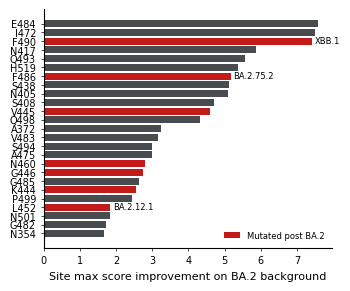

In [31]:
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max_large.nlargest(25, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()

ba2_new_mut = {346, 356, 368, 403, 444, 445, 446, 450, 452, 455, 456, 460, 481, 486, 490}

# Mapping of key BA.2 sublineage mutations to appearance variants
site_to_variant = {
    490: "XBB.1",
    486: "BA.2.75.2",
    452: "BA.2.12.1",
    456: "EG.5",
    450: "BA.2.3.20",
    # Add others if needed
}

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

# Small PRL-style figure (~1 column width, 8.6 cm)
fig, ax = plt.subplots(figsize=(3.4, 2.8))

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement on BA.2 background", fontsize=8)

# Clean frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()


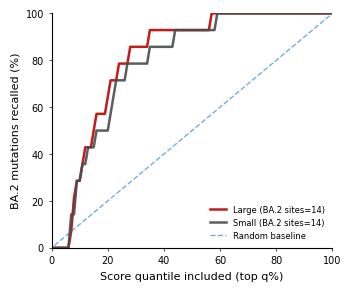

Large: Top  1% → recall   0.0% of 14 BA.2 sites
Large: Top  2% → recall   0.0% of 14 BA.2 sites
Large: Top  5% → recall   0.0% of 14 BA.2 sites
Large: Top 10% → recall  28.6% of 14 BA.2 sites
Small: Top  1% → recall   0.0% of 14 BA.2 sites
Small: Top  2% → recall   0.0% of 14 BA.2 sites
Small: Top  5% → recall   0.0% of 14 BA.2 sites
Small: Top 10% → recall  28.6% of 14 BA.2 sites


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs:
# - df_max_large, df_max_small: DataFrames with columns ['pos','max_score']
# - ba2_new_mut: set of integer site positions (post-BA.2)
score_col = "max_score"
site_col  = "pos"

# Palette, consistent with your earlier style
color_large = "#C31A1A"  # red highlight
color_small = "#494c4e"  # muted gray-blue

def recall_vs_quantile(df, ba2_sites, score_col="max_score", site_col="pos"):
    ranked = (
        df.dropna(subset=[score_col, site_col])
          .assign(pos=lambda d: d[site_col].astype(int))
          .sort_values(score_col, ascending=False)
          .reset_index(drop=True)
    )
    universe = set(ranked["pos"].tolist())
    ba2_here = set(int(s) for s in ba2_sites) & universe
    M = len(ba2_here)
    if M == 0:
        raise ValueError("No BA.2 sites found in this dataframe’s site universe.")

    ranked["is_ba2"] = ranked["pos"].isin(ba2_here)
    cum_ba2 = ranked["is_ba2"].cumsum().to_numpy()
    N = len(ranked)

    qs = np.arange(1, 101)  # 1..100%
    idx = np.ceil(qs / 100.0 * N).astype(int) - 1
    idx = np.clip(idx, 0, N - 1)

    recall_pct = cum_ba2[idx] / M * 100.0
    return qs, recall_pct, M, N

# Compute curves
qs_L, recall_L, M_L, N_L = recall_vs_quantile(df_max_large, ba2_new_mut, score_col, site_col)
qs_S, recall_S, M_S, N_S = recall_vs_quantile(df_max_small, ba2_new_mut, score_col, site_col)

# Plot (PRL-ish styling, no grid)
fig, ax = plt.subplots(figsize=(3.4, 2.8))
ax.plot(qs_L, recall_L, linewidth=1.8, label=f"Large (BA.2 sites={M_L})", color=color_large)
ax.plot(qs_S, recall_S, linewidth=1.8, label=f"Small (BA.2 sites={M_S})", color=color_small, alpha=0.9)

# Optional: random baseline (diagonal) for reference
ax.plot(np.arange(1,101), np.arange(1,101), linestyle="--", linewidth=1.0, alpha=0.6, label="Random baseline")

# Cosmetics
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel("Score quantile included (top q%)", fontsize=8)
ax.set_ylabel("BA.2 mutations recalled (%)", fontsize=8)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)
ax.legend(frameon=False, fontsize=6, loc="lower right")
plt.tight_layout(pad=0.3)
plt.show()

# Quick readouts at a few operating points
for name, qs, recall, M in [
    ("Large", qs_L, recall_L, M_L),
    ("Small", qs_S, recall_S, M_S),
]:
    for q in [1, 2, 5, 10]:
        print(f"{name}: Top {q:>2d}% → recall {recall[q-1]:5.1f}% of {M} BA.2 sites")
